In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
train_labels = r'C:\Users\msanj\cancer\train_labels_50.csv'

In [3]:
df = pd.read_csv(train_labels)


In [4]:
print(df['label'].value_counts(), 
      '\n\n', df.describe(), 
      '\n\n', df.head())

0    227
1    172
Name: label, dtype: int64 

             label
count  399.000000
mean     0.431078
std      0.495849
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000 

                                          id  label
0  0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0      0
1  0a0b4604d66cecfe668e26383c22fafb74484eef      0
2  0a0d55114d3c95af3033ed8b9cdbcee5c25489ee      0
3  0a0ea91e2384ba5b3a4ed15978815d357f76b262      1
4  0be670c324a230ee9d8307b9ccf4b8a9a0ea51fd      0


In [5]:
df["id"]=df["id"].apply(lambda x : x +".tif")
df['label'] = df['label'].astype('str')
df.head()

,id,label
0,0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif,0
1,0a0b4604d66cecfe668e26383c22fafb74484eef.tif,0
2,0a0d55114d3c95af3033ed8b9cdbcee5c25489ee.tif,0
3,0a0ea91e2384ba5b3a4ed15978815d357f76b262.tif,1
4,0be670c324a230ee9d8307b9ccf4b8a9a0ea51fd.tif,0


In [6]:
val = .15

datagen= ImageDataGenerator(
    rescale=1./255,
    samplewise_std_normalization= True,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    channel_shift_range=0.1,
    validation_split=val)

C:\Users\msanj\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [7]:
train_generator=datagen.flow_from_dataframe(
    dataframe=df,
    directory= r'C:\Users\msanj\cancer\cancer1',
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=128,
    shuffle=True,
    class_mode="binary",
    target_size=(96,96))



valid_generator=datagen.flow_from_dataframe(
    dataframe=df,
    directory= r'C:\Users\msanj\cancer\cancer1',
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=128,
    shuffle=True,
    class_mode="binary",
    target_size=(96,96))

Found 340 validated image filenames belonging to 2 classes.
Found 59 validated image filenames belonging to 2 classes.


In [8]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,Adamax,Nadam

In [9]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(96,96,3))


83689472/83683744 [==============================] - 135s 2us/step


In [10]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [11]:
base_model.trainable = True

In [12]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [23]:
best_w = ModelCheckpoint(r'C:\Users\msanj\cancer\best_xceptoion1.h5',
                        monitor='val_loss',
                        verbose=0,
                        save_best_only=True,
                        save_weights_only=True,
                        mode='auto',
                        period=3)
last_w = ModelCheckpoint(r'C:\Users\msanj\cancer\last_xception1.h5',
                        monitor='val_loss',
                        verbose=0,
                        save_best_only=False,
                        save_weights_only=True,
                        mode='auto',
                        period=1)

callbacks = [best_w,last_w]

In [27]:
adamax = Adamax(lr=0.002)

In [28]:
model.compile(optimizer=adamax,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [29]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.n//128, 
                              validation_data=valid_generator,
                              validation_steps=valid_generator.n//128,
                              epochs=5,
                              verbose=1,
                              callbacks=callbacks)


Epoch 1/5
2/2 [==============================] - 44s 22s/step - loss: 0.6866 - accuracy: 0.6085 - val_loss: 1.3163 - val_accuracy: 0.6271
Epoch 2/5
2/2 [==============================] - 48s 24s/step - loss: 0.6815 - accuracy: 0.5977 - val_loss: 1.3358 - val_accuracy: 0.6271
Epoch 3/5
2/2 [==============================] - 39s 20s/step - loss: 0.6469 - accuracy: 0.5660 - val_loss: 2.0163 - val_accuracy: 0.6949
Epoch 4/5
2/2 [==============================] - 48s 24s/step - loss: 0.5550 - accuracy: 0.6992 - val_loss: 2.5066 - val_accuracy: 0.7797
Epoch 5/5
2/2 [==============================] - 42s 21s/step - loss: 0.4543 - accuracy: 0.7547 - val_loss: 2.1215 - val_accuracy: 0.7288


In [30]:
test_path = r'C:\Users\msanj\cancer\test_20'

In [32]:
df_test = pd.read_csv(r'C:\Users\msanj\cancer\sample_submission.csv')
df_test["id"]=df_test["id"].apply(lambda x : x +".tif")

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 samplewise_std_normalization= True)

In [34]:
test_datagen= ImageDataGenerator(
    rescale=1./255,
    samplewise_std_normalization= True,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    channel_shift_range=0.1)

In [35]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col="id",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=128,
    class_mode=None,
    shuffle=False)

Found 70 validated image filenames.


C:\Users\msanj\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 57388 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [36]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=450,verbose=1).ravel()

450/450 [==============================] - 1395s 3s/step


In [37]:
results = dict(zip(test_generator.filenames, pred))

In [39]:
import glob
import os

path=glob.glob(r"C:\Users\msanj\cancer\test_20\*.tif")
file=os.listdir(r'C:\Users\msanj\cancer\test_20')
results

{'00cca1c4e98f0413c301f4896209412ee70de13b.tif': 0.9647147,
 '00a8ee1938f95219182f3ec07506ec8e496b4ce3.tif': 0.0,
 '00c9b8878669232e267d74008e40168cc9985af6.tif': 0.9994923,
 '00bf07acff499ec91dea7f19c398b8a3720e02fc.tif': 0.0,
 '00cc9f0b324bee545c2faf63f1290f1104f2fcec.tif': 0.1890521,
 '00af1151d5a87d93f50001e20236ec50ec6112e3.tif': 0.0,
 '00e3c08356c9952be5f6fcfcc6aff9df235c67de.tif': 1.0,
 '00e1d7656d92d3d6af9974b005ad129c8637b544.tif': 0.0,
 '00baf2602214addfcf6e8e6e4d3ebfbb17ec59fe.tif': 0.00015547872,
 '00b877a8a29237f9052d4f6ac1873145e714d3a9.tif': 0.0027939677,
 '00db7af1d8023068b730b952d6f0805dc8ac2e1e.tif': 1.4901161e-07,
 '00db76da84d723ad2641207ac82d7ba1798c576f.tif': 4.4703484e-07,
 '00c6a50db09c0d74ba86b14d0b7bc351efee4a29.tif': 0.0014438927,
 '00dc10f383fc2736de2f3b196e55c063b1d52ff2.tif': 0.00013133883,
 '00b0834ff7de02164bc1d58b4bf052cbe568a926.tif': 0.0,
 '00a2a7d5fbf50f1314a2f35e325c7cb452f4b5c8.tif': 0.006676078,
 '00bbb1701635b1a1c75190b625f1b83657183b2f.tif': 2.8

In [41]:
results1={}
for i in range(70):
  results1[file[i]]=results[file[i]]*100
results1

{'0000ec92553fda4ce39889f9226ace43cae3364e.tif': 97.50314950942993,
 '000c8db3e09f1c0f3652117cf84d78aae100e5a7.tif': 0.0,
 '000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe.tif': 99.99865293502808,
 '000e6341cf18365d35b40f4991002fec8834afc0.tif': 0.043782591819763184,
 '00a01a16ea56bcc9463351b6a5c3ca0fb0bf114c.tif': 0.9867101907730103,
 '00a0323dd32179f86fa3c817cabdfce0c5ae6bc8.tif': 0.0,
 '00a04c277c1a4bd14b7636d4c1c346d098a0f805.tif': 99.97684955596924,
 '00a1a702c655aa91b62ce07cc9885f3b625f6ff4.tif': 0.0,
 '00a283d23e79001ac8e765f57f0894ab89d29c59.tif': 1.1920928955078125e-05,
 '00a2a7d5fbf50f1314a2f35e325c7cb452f4b5c8.tif': 0.6676077842712402,
 '00a48832b0eda19d0365be0b35b165588e5f54d9.tif': 0.0002205371856689453,
 '00a8ee1938f95219182f3ec07506ec8e496b4ce3.tif': 0.0,
 '00a9d5b70627a6c469dc3b250b7750825e85ec65.tif': 100.0,
 '00add86d5243b3c083f37ebdf52aa9d59a8fd9e8.tif': 0.04241764545440674,
 '00af1151d5a87d93f50001e20236ec50ec6112e3.tif': 0.0,
 '00afd2ca902bcca7e24c2b4445971b5dc72c50bf.tif

In [43]:
results1['00db00b88dd96e11a35c80602f5b21adac26c584.tif']

0.0036954879760742188

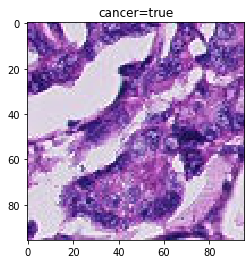

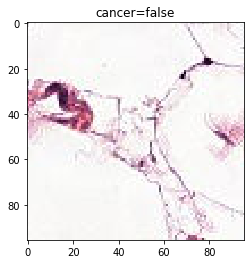

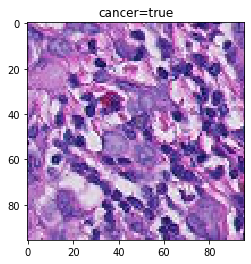

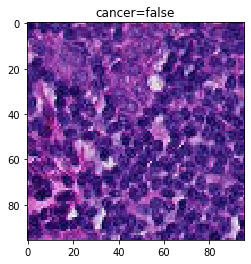

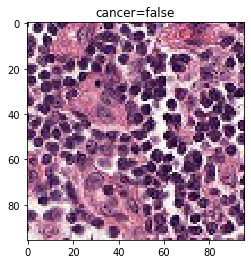

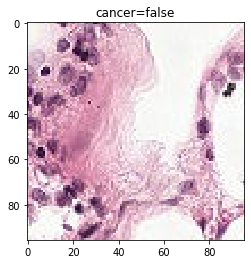

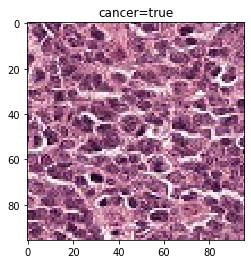

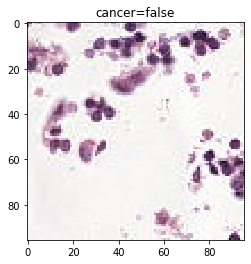

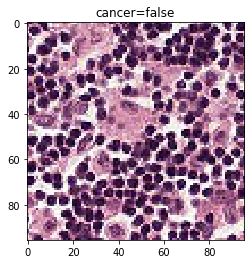

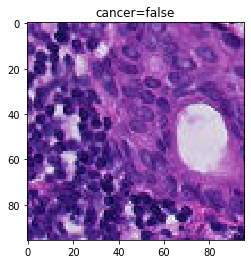

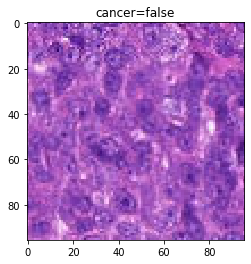

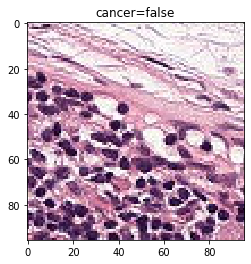

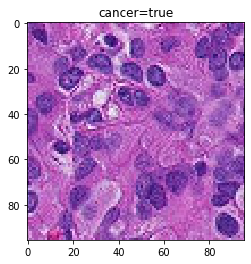

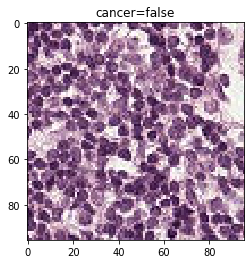

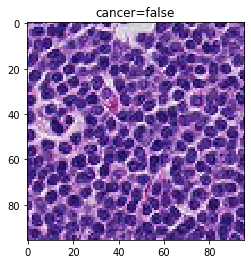

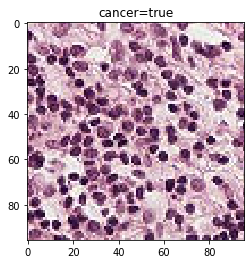

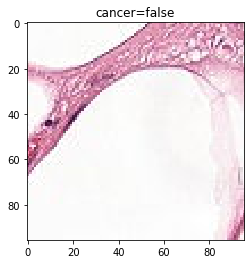

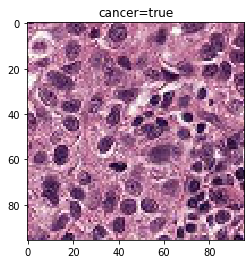

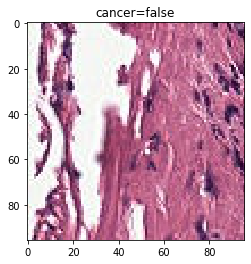

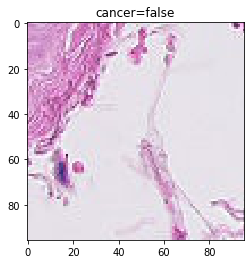

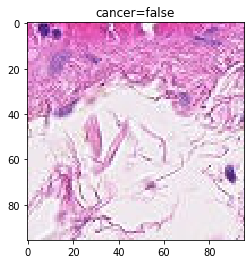

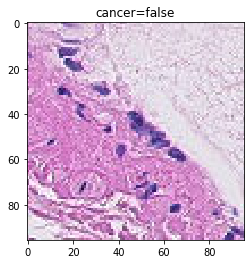

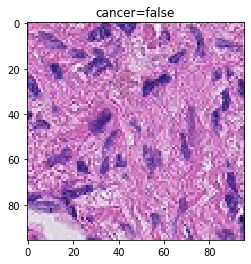

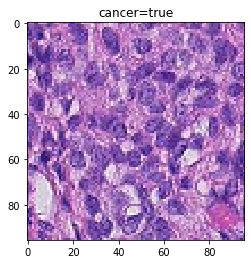

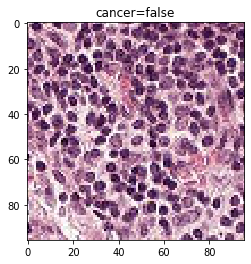

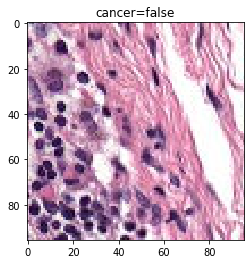

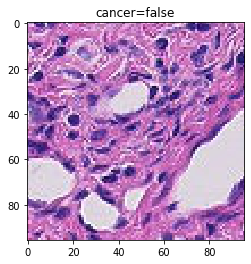

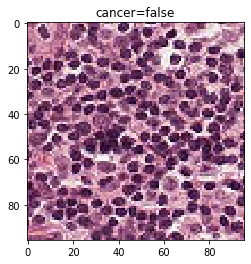

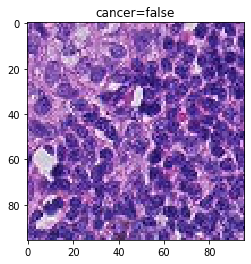

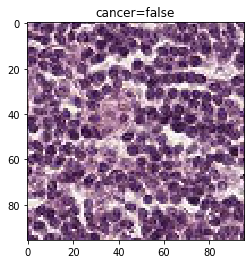

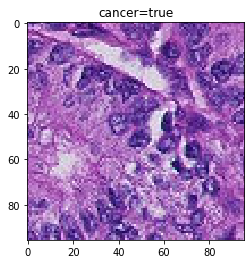

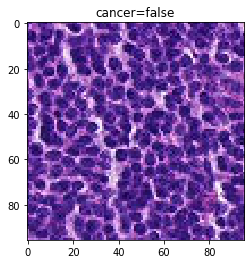

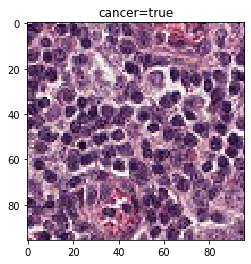

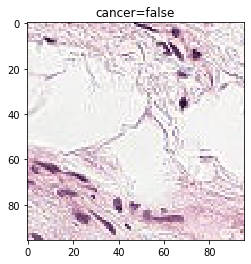

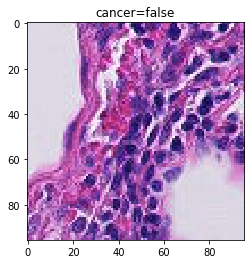

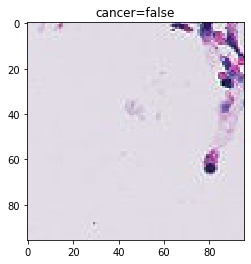

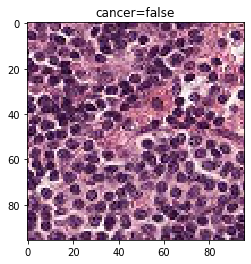

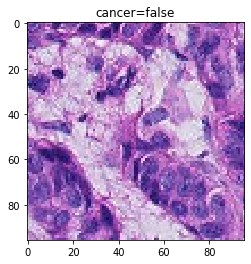

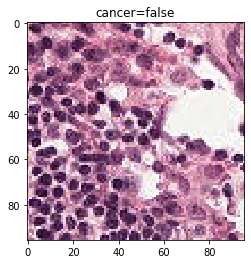

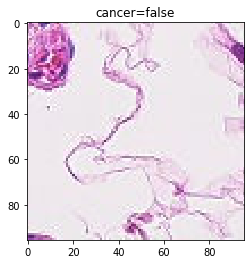

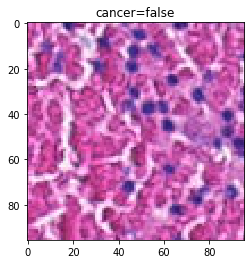

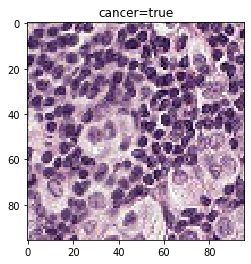

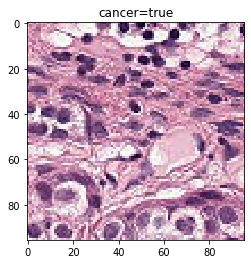

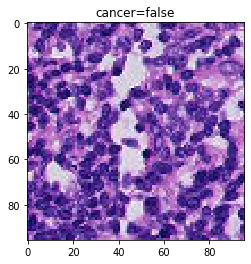

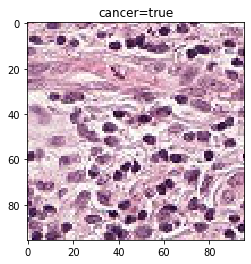

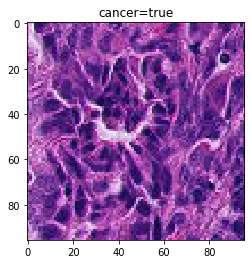

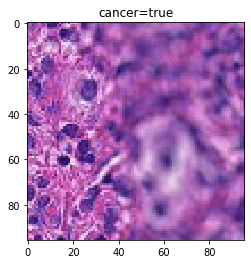

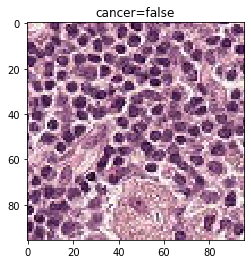

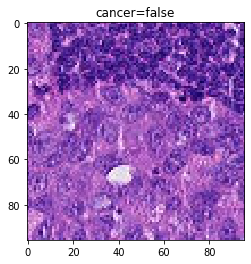

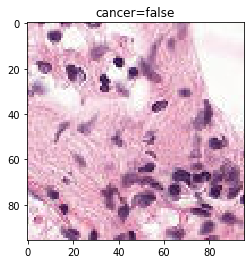

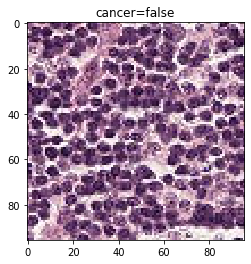

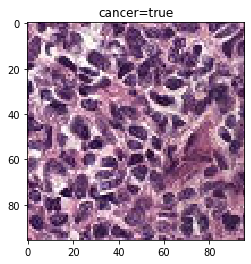

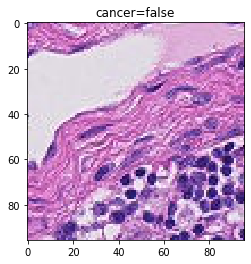

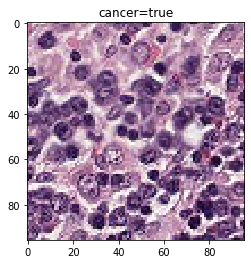

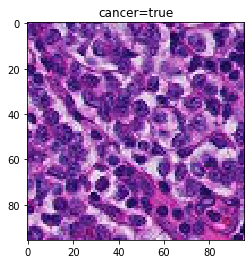

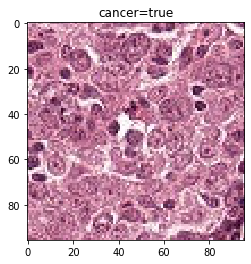

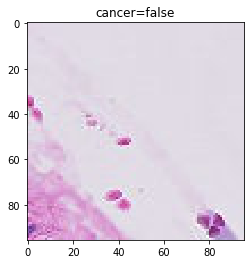

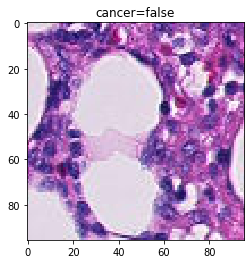

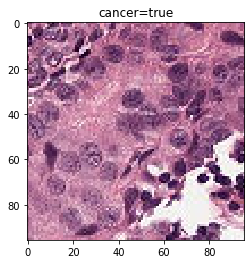

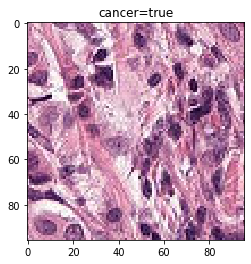

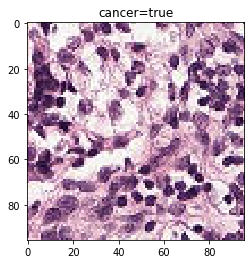

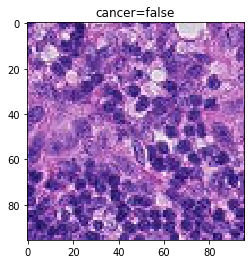

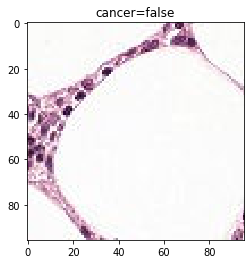

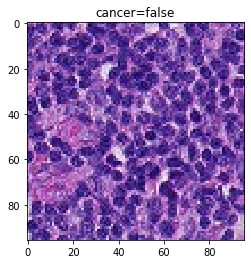

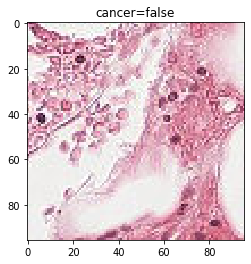

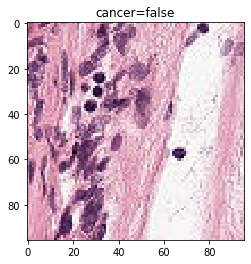

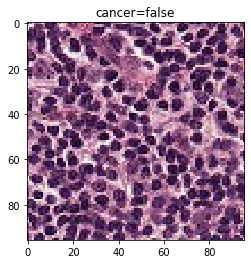

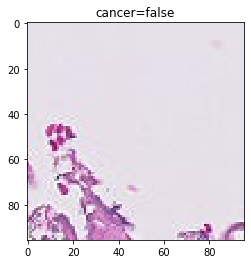

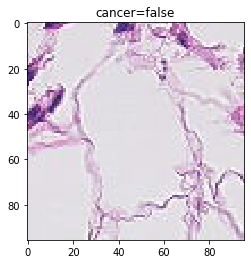

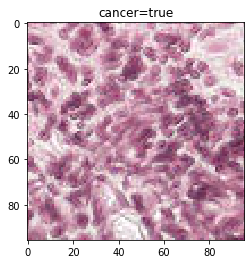

In [45]:
import matplotlib.image as mpimg
for i in range(70):
  img = mpimg.imread(path[i])
  plt.show()
  if(results1[file[i]]>50):
    plt.title('cancer=true')
  else:
    plt.title('cancer=false')
  plt.imshow(img)

In [46]:
temp=model.save(r'C:\Users\msanj\cancer\test_20\seq2.h5')

In [47]:
df=pd.DataFrame(list(results1.items()))
df.to_csv(r"C:\Users\msanj\cancer\results_cnn1.csv", index=False)
df.head()

,0,1
0,0000ec92553fda4ce39889f9226ace43cae3364e.tif,97.503150
1,000c8db3e09f1c0f3652117cf84d78aae100e5a7.tif,0.000000
2,000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe.tif,99.998653
3,000e6341cf18365d35b40f4991002fec8834afc0.tif,0.043783
4,00a01a16ea56bcc9463351b6a5c3ca0fb0bf114c.tif,0.986710
